# Time-dependent Quantum Mechanics workshop

The aim of this workshop is to explore the dynamics of a few simple 1D quantum models and characterise their dynamics.

## Note on the system of units

All the code we will be using in this workshop is written in the atomic system of units, which is characterised by setting the value of the following constants to unity:

* Electron mass m<sub>e</sub>=1.
* Magnitude of the electron charge e=1.
* Reduced Plank's constant &hbar;=1
* Coulomb's constant 1/(4&pi;&epsilon;<sub>0</sub>)=1.

This results in the following unit relations:

| Dimension | Atomic unit | Conversion to SI |
| --------- | ----------- | ---------------- |
| time | atomic time unit | 0.02419 fs |
| length | Bohr (a<sub>0</sub>) | 0.5292 &Aring; |
| mass | electron mass (m<sub>e</sub>) | 9.109&times;10<sup>-31</sup>kg |
| energy | Hartree (E<sub>h</sub>) | 4.360&times;10<sup>-18</sup>J |

For the type of systems we are using, the following relations for mass and energy are probably more useful: 1&nbsp;m<sub>e</sub> = 5.486&times;10<sup>-4</sup>&nbsp;g.mol<sup>-1</sup> and 1&nbsp;E<sub>h</sub> = 27.21&nbsp;eV.

## Discrete representation of the wavefunction

As a mathematical object, the wavefunction &psi;(x,t) is a complex (as in containing both real and imaginary parts) continuous function of x and t. Such continuous representation is not practical for a computer implementation, so both space and time are discretised in small intervals.
x can be represented as an array of real numbers representing a 1D grid of points in space. &psi; is going to be an array of complex numbers with the values of &psi; for each position of x at a given time t.

Let us start plotting some wavefunctions.

In [14]:
%pylab qt
# we don't use the usual 'inline' option, but choose a different backend,
# as the animations of the wavefunctions we will be seeing must run outside of the notebook.
# All the plots will show up on a separate window, but that is ok.

Populating the interactive namespace from numpy and matplotlib


The function gwp() below gives the values of a gaussian wavepacket wavefunction for a point in space for a given set of parameters.

In [2]:
def gwp(x,xc,pc,alpha,gamma):
    """Gaussian wavepacket in one dimension."""
    
    return (2/pi*real(alpha))**0.25 * exp(-alpha*(x-xc)**2 + 1j*pc*(x-xc) + 1j*gamma)

Set up a grid in space, choose some parameters, and plot the wavefunction (look at the magnitude, real and imaginary parts).

In [16]:
x=np.linspace(-3,9,200)
p=np.linspace(-3,9,200)

from ipywidgets import interact
@interact(alpha_r=(0.1,3,0.1),alpha_i=(-2,2,0.2),xc=(0,5,0.5),pc=(0,5,0.5),gamma_r=(0,2,0.2),gamma_i=(0,2,0.2))
def gwidth(alpha_r=1,alpha_i=0,xc=0,pc=3,gamma_r=0,gamma_i=0):
    fig,ax2 = plt.subplots(figsize=(6,4))

    plt.plot(x,np.abs(gwp(x,xc,pc,alpha_r+1j*alpha_i,gamma_r+1j*gamma_i)),color="gray",label="$|\\Psi(x,0)|$")
    plt.plot(x,np.real(gwp(x,xc,pc,alpha_r+1j*alpha_i,gamma_r+1j*gamma_i)),color="blue",label="$Re(\\Psi(x,0))$")
    plt.plot(x,np.imag(gwp(x,xc,pc,alpha_r+1j*alpha_i,gamma_r+1j*gamma_i)),color="red",label="$Imag(\\Psi(x,0))$")
    plt.legend(loc="upper right")
    ax2.set(xlabel="x",ylabel="$\\Psi(x,0)$",ylim=(-1.3,1.3))

interactive(children=(FloatSlider(value=1.0, description='alpha_r', max=3.0, min=0.1), FloatSlider(value=0.0, …

## Propagating the wavefunction in time

From the accompanying file qdyn.py we will be using the following two functions:

In [4]:
from qdyn import propagator, animate_dynamics

The function propagator() is responsible for evolving in time the wavefunction &psi;(x,t<sub>0</sub>) by a given time interval (time step) &Delta;t, to obtain &psi;(x,t<sub>0</sub>+&Delta;t). This operation is achieved by applying the time-evolution operator (or propagator):

$$\psi(x,t_0+\Delta t)=e^{-i \hat{H} \Delta t}\psi(x,t_0).$$

(Recall that in our system of units &hbar;=1.)

The evolution of the system in time will depend on the form of the Hamiltonian, more specifically on the form of the potential V(x). Below are defined a few simple potential functions.

In [5]:
def V_flat(x):
    "A flat potential"
    
    return 0*x

def V_step(x,pos,height):
    "Step potential"
    
    result=zeros(len(x))
    result[x>pos]=height
    return result

def V_harm(x,x0,k):
    "Harmonic oscillator"
    
    return k/2*(x-x0)**2



Let us now use the function propagator() to propagate the wavefunction you have defined above on a flat potential by one time step. Look at the help/documentation provided with the propagator() function to see what parameters it needs.

In [10]:
propagator?

You need to choose the mass of the system. It could be for example the reduced mass of the O<sub>2</sub> molecule. For the time step &Delta;t=500au is quite big (we will make it smaller later on). Make sure that your space grid is also big enough to "include all" the wavepacket.

In [6]:
m=14583 #reduced mass of O2 in atomic units
dt=5000 #time step in atomic units (this is a relatively big step)

x=np.linspace(-3,9,200)
alpha_r=1
alpha_i=0
xc=0
pc=3
gamma_r=0
gamma_i=0

psi0 = gwp(x,xc,pc,alpha_r+1j*alpha_i,gamma_r+1j*gamma_i)


new_wf=propagator(x,psi0,m,dt,V_flat)

Plot on the same figure the wavefunction before and after the propagation and see what happened.

In [10]:
plt.plot(x,new_wf,color="red",label="$|\\Psi(x,0)|$")
plt.plot(x,psi0,color="gray",label="$|\\Psi(x,0)|$")


To actually study the evolution of the wavefunction in time, we need to repeatedly apply the propagator and record the wavefunction after each time step propagation. We will thus construct a 2D array where each row in the wavefunction values for all points in space at a particular time t.

In [11]:
# Redefine a smaller time step
dt=50
# Define the number of time steps to perform during the simulation (how many times to apply the propagator)
nsteps=100
# Define the space grid
x_grid=np.linspace(-3,9,200)
# Define the initial wavefunction. You can choose a gaussian wavepacket.
psi0=gwp(x,xc,pc,alpha_r+1j*alpha_i,gamma_r+1j*gamma_i)

# Define an array full of zeros, big enough to contain the complex valued wavefunction
# the number of columns equals the number of space grid points, and the rows the number of time steps
wf_dynamics=zeros((nsteps+1,len(x_grid)),dtype=complex128)
# Add the initial wavefunction to the begining of the array with the wavefunction evolution
wf_dynamics[0]=psi0

for step in range(nsteps):
    psi=propagator(x_grid,wf_dynamics[step],m,dt,V_flat) # Apply the propagator to the wavefunction at current step in the array
    wf_dynamics[step+1]=psi # Add the new wavefunction to the array

It is important you understand how the code above is working as it is a template to use every time we want to propagate a wavefunction.

Now that we have an array with the wavefunction at different moments in time we can plot them in sequence to produce an animation using the function animate_dynamics(). (Check the function help to see how it is used.)

In [23]:
animate_dynamics?

In [12]:
animate_dynamics(x_grid,wf_dynamics,dt,V_flat(x_grid))


Depending on the number of steps in your dynamics and how you set up the system, the wavepacket might have reached the end of the space grid. If this happened you will see strage (unphysical) artifacts first appearing in the opposite end of the grid and expanding to all of the wavefunction. These are due to the technical implementation of the propagator, and it is important to be able to identify when it happens, since the results from that moment in time onwards are *completely unphysical* and cannot be used. **The remedy is to repeat the propagation with a bigger space grid.**

If your wavepacket did not reach the end of the grid, increase the number of time steps such as to observe the anomalous results.

### Step potential

Now we want to consider what happens to a wavepacket as we place an obstacle in its path. For that we use a step potential at the position x=pos. Set up a system starting as a gaussian wavepacket localised on x&lt;pos part of the grid and a positive momentum, such that its centre moves to higher x values.

In [ ]:
m=14583 #reduced mass of O2 in atomic units
dt=1500 #time step in atomic units (this is a relatively big step)

x=np.linspace(-3,9,200)
alpha_r=1
alpha_i=0
xc=0
pc=3
gamma_r=0
gamma_i=0

psi0 = gwp(x,xc,pc,alpha_r+1j*alpha_i,gamma_r+1j*gamma_i)

new_wf=propagator(x,psi0,m,dt,V_flat)

Choose the hight of the potential step, propagate the system in time and record the dynamics. You may want to use arrays with different names not to overwrite wf_dynamics.

Look at the dynamics of the system. Make sure you don't observe end of grid artifacts. If so, repeat the dynamics by adjusting the size of the space grid, the position of the step or the initial position of the wavepacket.

Repeat the dynamics adjusting the hight of the potential step (or the initial momentum of the wavepacket). What do you expect to happen when the kinetic energy of the centre of the wavepacket is lower than the potential step? And when it is larger?

### Harmonic oscillator

The function eigen_ho() below give the eigenfunctions of the harmonic oscillator centred at x=0 of any vibrational quantum number v.

In [ ]:
from numpy.polynomial.hermite import hermval

def eigen_ho(x,v,m,k):
    """Calculates the eigenfunction of the harmonic oscillator system.
    
    Arguments
    x: is a space coordinate.
    v: is the vibrational quantum number.
    m: is the mas of the system.
    k: is the force constant of the harmonic potential.
    """
    
    hermite_sum=zeros(v+1)
    hermite_sum[-1]=1
    return 1/(2**v * math.factorial(v))**0.5 * (((m*k)**0.5)/pi)**0.25 * np.e**(-x**2 * ((m*k)**0.5)/2) * hermval((m*k)**0.25 * x,hermite_sum) 

Consider an initial state which is one of the eigenstates of the system and propagate it in time.

You can try to use a frequency for the harmonic oscillator corresponding to some physical system (a diatomic molecule for example), or just choose an arbitrary value of 1, 2, 10, something else.

Consider now an initial state which is a linear combination of the first 2 eigenstates of the harmonic oscillator. Observe how the wavefunction evolves in time in this case.

Build an initial gaussian wavepacket on an harmonic potential and propagate it in time.

The condition on the &alpha; gaussian wavepacket parameter to obtain a coherent state is (in atomic units):

$$\alpha_0=\frac{m \omega}{2}=\frac{\sqrt{m k}}{2},$$

where &omega; and *k* are the numerical frequency and the force constant of the harmonic potential respectively.

Inspect the dynamics both of a coherent state, and a so called squeezed state.

### Other potentials

Time permitting, explore the dynamics in other potentials: something anharmonic (for example 4<sup>th</sup> order in x), the Morse potential, a smooth activation barrier,...

Before you do that, please make sure you obtain below an autocorrelation function and a spectrum of the systems you tried so far.

## Autocorrelation function

Now that we are equipped with a 2D array with the wavefunction at several moments in time, we can calculate the autocorrelation function of the system for those values of t.

$$\langle \psi(0) | \psi(t) \rangle = \int_{-\infty}^{\infty} \psi^*(x,0)\psi(x,t) dx.$$

The integral in practice will not involve infinity, but will be an integral of our space grid of points.

Such integral can be calculated using the trapezoidal rule implemented in Numpy function [trapz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.trapz.html).

In [ ]:
from numpy import trapz

To test the working of the integration let us use it in a known case:

In [ ]:
angle=linspace(0,pi/2,100)

# Note the somewhat unusual order of the arguments
trapz(cos(angle),angle)

For a dynamics run stored in a 2D array wf_dynamics, consider the result of the following operation which is an intermediate step in the calculation of the autocorrelation function

    conj(wf_dynamics[0])*wf_dynamics

Calculate and plot the autocorrelation function for one of the harmonic oscillator cases you studied above.

## The spectrum

The power spectrum of the system is calculated by doing the inverse Fourier transform of the autocorrelation function

$$S(\omega)=\frac{1}{\sqrt{2 \pi}}\int_{-\infty}^\infty \langle \psi(0) | \psi(t) \rangle e^{i \omega t} d t$$

Once more we need to discretise the integral and consider the limits with the interval of time for which we have autocorrelation function values. This is done by performing a discrete Fourier transform, which is implemented in the [numpy.fft](https://docs.scipy.org/doc/numpy/reference/routines.fft.html) submodule.

In [15]:
from numpy.fft import fft,ifft,fftshift,ifftshift,fftfreq

Even without going into the full details of the algorithm of the discrete Fourier transform, there are some details that we need to be aware of.

The discrete Fourier transform receives an array with the values of the function at discrete values in time, and returns an array with the values of the transformed function at discrete values of frequency.

Let us look at an example:

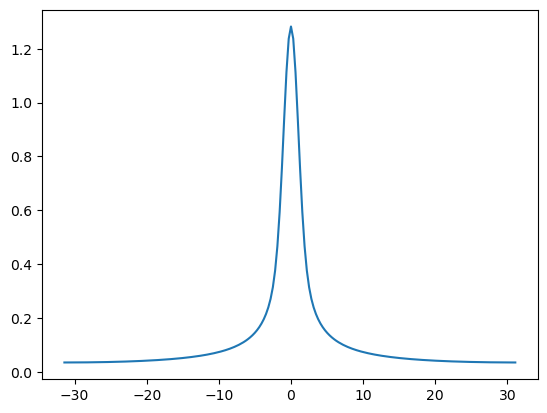

In [16]:
time=linspace(0,20,200) # Define a grid in time

gauss_t=e**(-time**2/4) # Define a gaussian function of time

# Obtain the inverse Fourier transform of gauss_t. Note that the values are shifted by fftshit()
gauss_w=ifftshift(ifft(gauss_t,norm="ortho")) 

# Obtain the grid of frequency values. The d keyword specifies the spacing between time points.
frequency=2*pi*fftshift(fftfreq(len(time),d=0.1)) 

plot(frequency,abs(gauss_w)) # Plot the transformed function
show()

Note that because of the inner working of the Fast Fourier Transform algorithm we are using, the result of the ifft() (and fftfreq()) functions is out of order: first all the positive frequency values are given and then all the negative values. The use of the fftshift() function give us arrays which are in the expected increasing frequency order.

The resolution &Delta;&omega; of the frequency grid depends on the total length of the time interval (the time range), so if N is the number of points in the time grid and &Delta;t the spacing between them, then

$$\Delta\omega=\frac{\sqrt{2\pi}}{N \Delta t}.$$

The range of the frequency grid, spanning from \[-&Omega;,&Omega;\] depends on the resolution of the time grid:

$$\Omega=\frac{\sqrt{\pi}}{\Delta t}.$$

If we thus want to increase the resolution of our spectrum, we must run the dynamics for longer and obtain the autocorrelation function at longer times. If we want to increase the range of frequencies in our spectrum (namely inspect high frequency components) we must use a smaller time step when propagating the wavefunction.

We can now do the Fourier transform of our autocorrelation function to obtain the power spectrum. It is interesting to look at the power spectrum of the harmonic oscillator system. Consider the following cases:

1. The initial wavefunction is a linear combination of two eigen states.
2. The initial wavefunction is a gaussian wavepacket.

It is always good to have an expected result in mind. What would the power spectra of these systems look like?